In [34]:
from deepface import DeepFace
import cv2
import os
import numpy as np

In [212]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [10]:
test_img_path = "../images/pic.jpg"

In [11]:
embedding_obj = DeepFace.represent(img_path=test_img_path)

In [12]:
embedding_obj

[{'embedding': [0.015251470729708672,
   0.02539754845201969,
   0.010369979776442051,
   0.007055041845887899,
   0.03104546293616295,
   0.01587481051683426,
   0.016045933589339256,
   0.01742822676897049,
   0.01894203945994377,
   0.012966817244887352,
   0.01656324602663517,
   0.01125730387866497,
   0.014370572753250599,
   0.02037505991756916,
   0.016950620338320732,
   0.004389560781419277,
   0.020874623209238052,
   0.013411867432296276,
   0.020718684419989586,
   0.01565437763929367,
   0.016668526455760002,
   0.019298139959573746,
   0.01033125538378954,
   0.016130320727825165,
   0.025881340727210045,
   0.015155184082686901,
   0.008494066074490547,
   0.024556871503591537,
   0.01818683370947838,
   0.016046997159719467,
   0.028968196362257004,
   0.01643386483192444,
   0.010005231946706772,
   0.014284285716712475,
   0.0037287604063749313,
   0.011332659050822258,
   0.01974840834736824,
   0.0023193350061774254,
   0.018779277801513672,
   0.019282571971416473

face_area = embedding_obj[0]['facial_area']
embed_array = embedding_obj[0]['']

In [13]:
face_area = embedding_obj[0]['facial_area']
embed_array = embedding_obj[0]['embedding']

In [16]:
img_embedding = get_embedding(test_img_path)

In [17]:
len(img_embedding)

2622

In [18]:
pos_test_img_1 = "../images/pic.jpg"
pos_test_img_2 = "../images/1e8dca3e-8ac7-11ee-99b2-fc77742df978.jpg"
pos_test_img_3 = "../images/1eb5e9f7-8ac7-11ee-b510-fc77742df978.jpg"
neg_test_img_1 = "../images/Bill_Gates_0010.jpg"
neg_test_img_2 = "../images/Aaron_Sorkin_0001.jpg"

In [19]:
pos_embed_1 = get_embedding(pos_test_img_1)
pos_embed_2 = get_embedding(pos_test_img_2)
pos_embed_3 = get_embedding(pos_test_img_3)
neg_embed_1 = get_embedding(neg_test_img_1)
neg_embed_2 = get_embedding(neg_test_img_2)

In [20]:
similar_1 = cosine_similarity(pos_embed_1, pos_embed_3)
similar_2 = cosine_similarity(pos_embed_2, pos_embed_3)
similar_3 = cosine_similarity(pos_embed_1, pos_embed_2)

dissimilar_1 = cosine_similarity(neg_embed_1, pos_embed_2)
dissimilar_2 = cosine_similarity(neg_embed_1, pos_embed_1)
dissimilar_3 = cosine_similarity(neg_embed_2, pos_embed_3)

In [21]:
print("similar({},{},{})\ndissimlar({},{},{})".format(similar_1,similar_2,similar_3,dissimilar_1,dissimilar_2,dissimilar_3))

similar(0.4100760005052697,0.8095062998226382,0.2564178575094623)
dissimlar(0.42007892142083847,0.3510020301510744,0.4977876630880874)


In [22]:
def store_embedding(IMG_PATH):
    data_embed = {}
    for dirs in os.listdir(IMG_PATH):
        if dirs not in data_embed.keys():
            data_embed[dirs] = []
        for obj in os.listdir(os.path.join(IMG_PATH, dirs)):
            path = os.path.join(IMG_PATH, dirs, obj)
            if path.endswith(".jpg"):
                try:
                    embed_arr = get_embedding(path)
                    data_embed[dirs].append(embed_arr)
                except ValueError:
                    print("Face detection error in dir {}".format(dirs))
                    

    return data_embed
                

In [23]:
IMG_PATH = "../images/img_db/"
embed_dict = store_embedding(IMG_PATH)

Face detection error in dir ape173411
Face detection error in dir aph173490
Face detection error in dir csp175417
Face detection error in dir mme173416


In [24]:
embed_dict

{'ape173411': [],
 'aph173490': [],
 'csp175417': [],
 'eee173416': [array([ 0.01366778,  0.00587467, -0.00023822, ..., -0.01124056,
          0.00678611,  0.00511611]),
  array([ 0.01796371, -0.00461304,  0.00389931, ..., -0.01491167,
          0.0117327 ,  0.01515537])],
 'fst183416': [array([ 0.00107188, -0.00468277, -0.00379027, ..., -0.01439047,
          0.01639554,  0.00566958]),
  array([ 0.0025439 , -0.00569593, -0.00400404, ..., -0.01414153,
          0.01734357,  0.00645685])],
 'ipe173416': [array([ 0.01213332, -0.00576494,  0.00817925, ..., -0.01169322,
          0.009633  ,  0.006151  ]),
  array([ 0.01208288, -0.00375242,  0.00725141, ..., -0.01141528,
          0.00887036,  0.00594898])],
 'ipe173419': [array([ 0.00818483, -0.00434986, -0.00543791, ..., -0.00461443,
          0.01006278,  0.01616117])],
 'ipe188560': [array([ 0.02262301,  0.01865259, -0.00289194, ..., -0.01532963,
          0.01266199,  0.01094251])],
 'mcs172755': [array([ 0.02577881,  0.00853649, -0.0

In [35]:
def cosine_similarity(first_embedding, second_embedding):
    dot_product = np.dot(first_embedding,second_embedding)
    norm_a = np.linalg.norm(first_embedding)
    norm_b = np.linalg.norm(second_embedding)
    similarity = dot_product / (norm_a * norm_b)

    return similarity

In [36]:
def get_embedding(img):
    embed = DeepFace.represent(img)
    embed_arr = np.array(embed[0]['embedding'])

    return embed_arr

In [65]:
def detect_image(img, embed_dict, id):
    similarity_index = 0.3
    most_similar_index = 1
    test_embed = get_embedding(img)
    print(test_embed)
    for embed in embed_dict[id]:
        index = cosine_similarity(test_embed, embed)
        if index < most_similar_index:
            most_similar_index = index
        
    if most_similar_index <= similarity_index:
        print("image match correctly with {:.3f} similarity index".format(most_similar_index))
        return True
    else:
        print("image do not match")
        print(most_similar_index)
    

[0.01525147 0.02539755 0.01036998 ... 0.00154433 0.01293933 0.01905597]
image do not match
image do not match
image do not match
image do not match


In [66]:
pos_test_img_1 = "../images/pic.jpg"
myid = 'mme173416'

In [67]:
check = detect_image(pos_test_img_1, embed_dict, myid)

[0.01525147 0.02539755 0.01036998 ... 0.00154433 0.01293933 0.01905597]
image match correctly with 0.283 similarity index


In [ ]:
# process the image to get the image id
# if corressponding user not found, throw error that user not in database
# Expected return imageid
image_id = process_image_id(image_file)

if image_id == "error":
    return jsonify({'message': 'User not found'}), 404

In [207]:
def process_image_id(image_file, embed_dict):
    best_match = {'match':0.25}
    ID = None

    # get embedding from img_file
    img_embed_arr = get_embedding(image_file)

    for id, embeddings in embed_dict.items():
        if embeddings:
            for embedding in embeddings:
                similarity_check = cosine_similarity(img_embed_arr, embedding)
                if similarity_check < best_match['match']:
                    best_match[id] = id
                    best_match['embedding'] = embedding
                    best_match['match'] = similarity_check
                    ID = id
                    print("Match found")

    if ID is not None:
        return ID
    else:
        return "User not in database"
        
    

    # check embedding in embed_dict
    # if embedding in embed_dict
    # return id [key]
    # if embedding not in embed_dict
    # return error


In [208]:
img_file = "../images/passport .jpg"

In [209]:
out = process_image_id(img_file, embed_dict)

In [210]:
out

'User not in database'

In [142]:
embed_dict['eee173416']

[array([ 0.01366778,  0.00587467, -0.00023822, ..., -0.01124056,
         0.00678611,  0.00511611]),
 array([ 0.01796371, -0.00461304,  0.00389931, ..., -0.01491167,
         0.0117327 ,  0.01515537])]

In [187]:
import json

In [189]:
np.savez('embed_dict.npz', **embed_dict)

In [211]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [213]:
embedding = make_embedding()

In [217]:
input_image = Input(name='input_img', shape=(100,100,3))
ck_embed = embedding(img_file)

TypeError: Inputs to a layer should be tensors. Got '../images/passport .jpg' (of type <class 'str'>) as input for layer 'embedding'.

In [218]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# Load the ResNet50 model pretrained on ImageNet 
model = ResNet50(weights='imagenet')

# Load the image and preprocess it
img_path = "../images/passport .jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract the embeddings
features = model.predict(x)
image_embeddings = features.reshape((features.shape[0], -1))

# image_embeddings now contains the embeddings for this image
print(image_embeddings.shape)

1/1 [==============================] - 4s 4s/step
(1, 1000)


In [220]:
def get_img_embed(img_path):
    img_path = "../images/passport .jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract the embeddings
    features = model.predict(x)
    image_embeddings = features.reshape((features.shape[0], -1))

    return image_embeddings

In [221]:
embed = get_img_embed(img_file)

1/1 [==============================] - 0s 237ms/step


In [223]:
embed.shape

(1, 1000)

In [68]:
try_dict = {'a':[1,2,3,4,5], 'b':[6,7,8,9,0], 'c':[12,13,14,15,16]}

In [73]:
try_dict.values()

dict_values([[1, 2, 3, 4, 5], [6, 7, 8, 9, 0], [12, 13, 14, 15, 16]])

In [91]:
for key, value in try_dict.items():
    if 16 in value:
        print(f"16 is found on key {key}")

16 is found on key c


In [94]:
try_dict['a'] = [2,4,6,8,0]

In [95]:
try_dict

{'a': [2, 4, 6, 8, 0], 'b': [6, 7, 8, 9, 0], 'c': [12, 13, 14, 15, 16]}

In [1]:
def get_image_id(image):
        
        pass

def process_image_id(image):
        pass

In [229]:
import face_recognition
import cv2
import os
import numpy as np

# Step 1 - Encode all known faces

known_faces_dir = "known_faces"
known_faces = []
known_names = []  

for name in os.listdir(known_faces_dir):
    image = face_recognition.load_image_file(f"{known_faces_dir}/{name}")
    encoding = face_recognition.face_encodings(image)[0]
    known_faces.append(encoding)
    known_names.append(name)

# Step 2 - Make attendance dict 

attendances = {}
for name in known_names:
    attendances[name] = False

# Step 3 - Recognize faces in webcam frame and mark attendance

video_capture = cv2.VideoCapture(0)

while True:
    ret, frame = video_capture.read()
    
    # Detect all faces and face encodings in current frame
    face_locations = face_recognition.face_locations(frame)
    face_encodings = face_recognition.face_encodings(frame, face_locations)

    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        
        # See if this face matches any known face
        match = face_recognition.compare_faces(known_faces, face_encoding, tolerance=0.6)
        
        # If match, identify the name and mark attendance
        name = "Unknown"
        
        if True in match:
            first_match_index = match.index(True)
            name = known_names[first_match_index]
            attendances[name] = True
        
        # Draw rectangle and write name            
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)  
        cv2.putText(frame, name, (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 255, 255), 1)

    # Display webcam frame
    cv2.imshow('Webcam_facerecognition', frame) 

    # Press esc to exit
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
# Print final attendances        
print(attendances)

video_capture.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'face_recognition'

In [264]:
backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe',
  'yolov8',
  'yunet',
  'fastmtcnn',
]

In [331]:
from deepface import DeepFace
import cv2
import os

# Step 1 - Encode all known faces
known_faces_dir = "../images/img_db/"
known_faces = []
known_names = []

for name in os.listdir(known_faces_dir):
  sub_dir = os.path.join(known_faces_dir, name)
  for img in os.listdir(sub_dir):
    if img.endswith(".jpg"):
      try:
        image = DeepFace.represent(img_path=f"{sub_dir}/{img}", model_name='Facenet512')  
        encoding = image[0]['embedding']
        known_faces.append(encoding)
        known_names.append(name)
      except ValueError:
        print("skipping image")
        pass
  
# Step 2 - Make attendance dict
attendances = {}
for name in known_names:
  attendances[name] = False
   
# Step 3 - Recognize faces in webcam and mark attendance 
video_capture = cv2.VideoCapture(0)

while True:
  ret, frame = video_capture.read()
  # print(frame)
  try:
    # Detect Faces 
    detected_face = DeepFace.extract_faces(img_path = frame, target_size=(224,224), detector_backend=backends[3])
  except ValueError:
    print("skipping detection")
    pass
  
  for face in detected_face:
    print(face)
    x, y, width, height = face['facial_area'].values()
    
    # Crop detected face
    crop_img = frame[y:y+height, x:x+width]
    
    # Recognize face        
    encoding = DeepFace.represent(img_path=crop_img, model_name='Facenet512', enforce_detection=False)[0]['embedding']
      
    name = 'Unknown'
    encoding_np = np.full(512, encoding)
   
    if len(known_faces) > 0:  
      matches = DeepFace.find(encoding_np, known_faces, model_name='Facenet512', distance_metric='euclidean_l2')
      
      if matches['identity'] is not None:
        name = known_names[matches['identity']]
        attendances[name] = True
        
    cv2.rectangle(frame,(x,y),(x+width, y+height),(0,0,255),3)  
    cv2.putText(frame,name,(x,y+height+15), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2)  
  
  # Show video feed  
  cv2.imshow('Attendance System', frame) 

  # Press esc to exit  
  if cv2.waitKey(1) & 0xFF == 27:
    break

print(attendances)

video_capture.release()
cv2.destroyAllWindows()

skipping image
3/3 [==============================] - 0s 36ms/step
{'face': array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), 'facial_area'

TypeError: stat: path should be string, bytes, os.PathLike or integer, not list

In [330]:
len(known_faces)

21

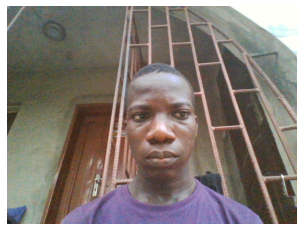

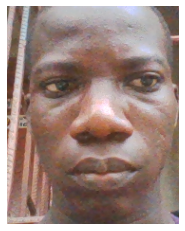

In [326]:
visulaize_frame(frame)
visulaize_frame(crop_img)

In [299]:
import matplotlib.pyplot as plt
%matplotlib inline
# visualise the frame
def visulaize_frame(frame):
    # Convert BGR to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [ ]:
import cv2

def register_new_face(name):
  
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  
  cap = cv2.VideoCapture(0)
  while True:
    
    ret, frame = cap.read()
   
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)
    
    for (x, y, w, h) in faces:
      cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 3)
      face_img = gray_frame[y:y+h, x:x+w]
      face_img = cv2.resize(face_img, (224, 224))
      
    cv2.imshow('Register Face', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
      
    elif cv2.waitKey(1) == ord('c'):
      
      # Save extracted face
      face_path = "../images/known_faces/"+name+".jpg"  
      cv2.imwrite(face_path, face_img)
      print(f"{name}'s face saved!")
      
      break
  
  cap.release()
  cv2.destroyAllWindows()
       

# Call this function to add new face   
register_new_face("John")

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
